# Introduction

If someone has an idea for a new classifier, it should compare the performance of its new classifier with the performance of standard classifiers on some standard datasets.

But what are the performances of these standard classifiers on these standard datasets?

This notebook tries to answer this question.

# TensorFlow Version check

In [1]:
import tensorflow as tf
from tensorflow import keras

print(tf.__version__)

2.0.0


# Set experiment parameters

In [2]:
PARAM_NR_TEST_IMAGES = 10000
PARAM_NR_TRAIN_EPOCHS = 100

# Model test function

In [9]:
def model_test(your_model, x_test, y_test, how_many_to_test, model_type="MLP", img_shape=None):
        
    correct = 0
    for sample_id in range(0, how_many_to_test):
        
        if sample_id % 100 == 0:
            print("tested so far {0} of {1} images".format(sample_id, how_many_to_test))

        # get next test sample
        input_vec   = x_test[sample_id]
        teacher_vec = y_test[sample_id]
        
        # compute prediction vector
                
        if model_type == "MLP":
            
            # note: the input to a MLP is a batch of 1D inputs, so 2D!
            pred_vec = your_model.predict( input_vec.reshape(1, -1) )
            
            
        elif model_type == "CNN":
            
            # note: the input to a CNN is a batch of 3D inputs, so 3D!
            # 1 test image
            # h pixel high
            # w pixel wide
            # c color channels
            # --> shape is (1,h,w,c)
            h = img_shape[0]
            w = img_shape[1]
            c = img_shape[2]
            pred_vec = your_model.predict( input_vec.reshape(1,h,w,c) )
        
        # compute predicted label
        pred_label = np.argmax( pred_vec )
        
        # get actual label
        gt_label = np.argmax( teacher_vec )
        
        #print("pred: {0} vs. gt: {1}".format(pred_label, gt_label))
        
        # was the predicted label correct?
        if pred_label == gt_label:
            correct += 1
            
    acc = correct/how_many_to_test
    return acc

# MNIST

## Preparing the dataset

In [ ]:
import numpy as np

def prepare_data():
    
    # 1. load MNIST dataset
    mnist_dataset = tf.keras.datasets.mnist
    (x_train, y_train), (x_test, y_test) = mnist_dataset.load_data()
    
    # 2. map image pixel values from [0,255] to [0,1]
    x_train = x_train.astype(float)
    x_test  = x_test.astype(float)
    
    x_train = x_train * (1.0/255.0)
    x_test  = x_test  * (1.0/255.0)
    
    # 3. images are 2D, prepare input as 1D input for a MLP
    x_train = x_train.reshape(-1,28*28)
    x_test  = x_test.reshape(-1,28*28)
    
    # 4. map train data target labels to one-hot encoded vectors
    y_train_onehot = np.zeros((y_train.size, y_train.max()+1))
    y_train_onehot[np.arange(y_train.size),y_train] = 1
    
    # 5. map test data target labels to one-hot encoded vectors
    y_test_onehot = np.zeros((y_test.size, y_train.max()+1))
    y_test_onehot[np.arange(y_test.size),y_test] = 1
    
    return x_train, y_train_onehot, \
           x_test,  y_test_onehot

# get MNIST data now
x_train, y_train, x_test, y_test = prepare_data()

In [ ]:
x_train.shape

In [ ]:
y_train.shape

In [ ]:
y_train[:5]

In [ ]:
x_test.shape

In [ ]:
y_test.shape

In [ ]:
from matplotlib import pyplot as plt

for i in range(0,5):
    plt.imshow( x_train[i,:].reshape(28,28), cmap="gray" )
    plt.colorbar()
    plt.show()

## Perceptron

In [ ]:
from tensorflow import keras

tf.keras.backend.clear_session()

nr_inputs = 28*28

model = keras.Sequential()
model.add(keras.layers.Dense(10,
                             activation="linear",
                             input_shape=(nr_inputs,)))
model.compile(optimizer='sgd',               
              loss=tf.keras.losses.MeanSquaredError(),
              metrics=['accuracy'])

In [ ]:
model.summary()

In [ ]:
model_test(model, x_test, y_test, PARAM_NR_TEST_IMAGES)

In [ ]:
history = model.fit(x_train, y_train, epochs=PARAM_NR_TRAIN_EPOCHS, validation_split=0.1)

In [ ]:
model_test(model, x_test, y_test, PARAM_NR_TEST_IMAGES)

## MLP

In [ ]:
tf.keras.backend.clear_session()

nr_inputs = 28*28

model = keras.Sequential()
model.add(keras.layers.Dense(200,
                             activation="relu",
                             input_shape=(nr_inputs,)))
model.add(keras.layers.Dense(50,
                             activation="relu"))
model.add(keras.layers.Dense(10,
                             activation="linear"))
model.compile(optimizer='sgd',               
              loss=tf.keras.losses.MeanSquaredError(),
              metrics=['accuracy'])
model.summary()

In [ ]:
model_test(model, x_test, y_test, PARAM_NR_TEST_IMAGES)

In [ ]:
history = model.fit(x_train, y_train, epochs=PARAM_NR_TRAIN_EPOCHS, validation_split=0.1)

In [ ]:
model_test(model, x_test, y_test, PARAM_NR_TEST_IMAGES)

## CNN

In [ ]:
from tensorflow import keras
from tensorflow.keras.models import Sequential
from tensorflow.keras import layers
from tensorflow.keras.layers import Dense
from tensorflow.keras import backend as K
from tensorflow.keras import losses

K.clear_session()

model = keras.Sequential()

model.add(layers.Conv2D(64, (3, 3), activation='relu', input_shape=(28, 28, 1)))
model.add(layers.MaxPooling2D((2, 2)))

model.add(layers.Conv2D(32, (3, 3), activation='relu'))
model.add(layers.MaxPooling2D((2, 2)))

model.add(layers.Conv2D(16, (3, 3), activation='relu'))
model.add(layers.MaxPooling2D((2, 2)))

model.add(layers.Flatten())

model.add(layers.Dense(512, activation='relu', name="FC"))

model.add(layers.Dense(10, activation='linear', name="output"))

model.compile(loss=losses.mean_squared_error, optimizer='sgd')

model.summary()

In [ ]:
model_test(model,
           x_test,
           y_test,
           how_many_to_test=500,
           model_type="CNN"
          )

In [ ]:
history = model.fit(x_train.reshape(60000, 28,28,1),
                    y_train,
                    epochs=PARAM_NR_TRAIN_EPOCHS/2,
                    validation_split=0.1)

In [ ]:
model_test(model, x_test, y_test, PARAM_NR_TEST_IMAGES)

# Fashion MNIST

Why Fashion-MNIST?

See https://github.com/zalandoresearch/fashion-mnist:

Quote from the Fashion-MNIST GitHub website:

    To Serious Machine Learning Researchers

    Seriously, we are talking about replacing MNIST. Here are some good reasons:

    MNIST is too easy. Convolutional nets can achieve 99.7% on MNIST. Classic machine learning algorithms can also achieve 97% easily. Check out our side-by-side benchmark for Fashion-MNIST vs. MNIST, and read "Most pairs of MNIST digits can be distinguished pretty well by just one pixel."

    MNIST is overused. In this April 2017 Twitter thread, Google Brain research scientist and deep learning expert Ian Goodfellow calls for people to move away from MNIST.

    MNIST can not represent modern CV tasks, as noted in this April 2017 Twitter thread, deep learning expert/Keras author François Chollet.


## Preparing the dataset

In [ ]:
import numpy as np

def prepare_data():
    
    # 1. load FASHION MNIST dataset
    fashionmnist_dataset = keras.datasets.fashion_mnist
    (x_train, y_train), (x_test, y_test) = fashionmnist_dataset.load_data()
    
    # 2. map image pixel values from [0,255] to [0,1]
    x_train = x_train.astype(float)
    x_test  = x_test.astype(float)
    
    x_train = x_train * (1.0/255.0)
    x_test  = x_test  * (1.0/255.0)
    
    # 3. images are 2D, prepare input as 1D input for a MLP
    x_train = x_train.reshape(-1,28*28)
    x_test  = x_test.reshape(-1,28*28)
    
    # 4. map train data target labels to one-hot encoded vectors
    y_train_onehot = np.zeros((y_train.size, y_train.max()+1))
    y_train_onehot[np.arange(y_train.size),y_train] = 1
    
    # 5. map test data target labels to one-hot encoded vectors
    y_test_onehot = np.zeros((y_test.size, y_train.max()+1))
    y_test_onehot[np.arange(y_test.size),y_test] = 1
    
    return x_train, y_train_onehot, \
           x_test,  y_test_onehot

# get FASHION MNIST data now
x_train, y_train, x_test, y_test = prepare_data()

In [ ]:
x_train.shape

In [ ]:
x_test.shape

In [ ]:
y_train.shape

In [ ]:
y_test.shape

In [ ]:
y_train[:5]

## Perceptron

In [ ]:
from tensorflow import keras

tf.keras.backend.clear_session()

nr_inputs = 28*28

model = keras.Sequential()
model.add(keras.layers.Dense(10,
                             activation="linear",
                             input_shape=(nr_inputs,)))
model.compile(optimizer='sgd',               
              loss=tf.keras.losses.MeanSquaredError(),
              metrics=['accuracy'])
model.summary()

In [ ]:
model_test(model, x_test, y_test, PARAM_NR_TEST_IMAGES)

In [ ]:
history = model.fit(x_train, y_train, epochs=PARAM_NR_TRAIN_EPOCHS, validation_split=0.1)

In [ ]:
model_test(model, x_test, y_test, PARAM_NR_TEST_IMAGES)

## MLP

In [ ]:
tf.keras.backend.clear_session()

nr_inputs = 28*28

model = keras.Sequential()
model.add(keras.layers.Dense(200,
                             activation="relu",
                             input_shape=(nr_inputs,)))
model.add(keras.layers.Dense(50,
                             activation="relu"))
model.add(keras.layers.Dense(10,
                             activation="linear"))
model.compile(optimizer='sgd',               
              loss=tf.keras.losses.MeanSquaredError(),
              metrics=['accuracy'])
model.summary()

In [ ]:
model_test(model, x_test, y_test, PARAM_NR_TEST_IMAGES)

In [ ]:
history = model.fit(x_train, y_train, epochs=PARAM_NR_TRAIN_EPOCHS, validation_split=0.1)

In [ ]:
model_test(model, x_test, y_test, PARAM_NR_TEST_IMAGES)

## CNN

In [ ]:
from tensorflow import keras
from tensorflow.keras.models import Sequential
from tensorflow.keras import layers
from tensorflow.keras.layers import Dense
from tensorflow.keras import backend as K
from tensorflow.keras import losses

K.clear_session()

model = keras.Sequential()

model.add(layers.Conv2D(64, (3, 3), activation='relu', input_shape=(28, 28, 1)))
model.add(layers.MaxPooling2D((2, 2)))

model.add(layers.Conv2D(32, (3, 3), activation='relu'))
model.add(layers.MaxPooling2D((2, 2)))

model.add(layers.Conv2D(16, (3, 3), activation='relu'))
model.add(layers.MaxPooling2D((2, 2)))

model.add(layers.Flatten())

model.add(layers.Dense(512, activation='relu', name="FC"))

model.add(layers.Dense(10, activation='linear', name="output"))

model.compile(loss=losses.mean_squared_error, optimizer='sgd')

model.summary()

In [ ]:
model_test(model,
           x_test,
           y_test,
           how_many_to_test=500,
           model_type="CNN"
          )

In [ ]:
history = model.fit(x_train.reshape(60000, 28,28,1),
                    y_train,
                    epochs=int(PARAM_NR_TRAIN_EPOCHS/2),
                    validation_split=0.1)

In [ ]:
model_test(model,
           x_test,
           y_test,
           PARAM_NR_TEST_IMAGES,
           model_type="CNN")

# Bikes vs. Cars

## Preparing the dataset

under folder
	 /home/juebrauer/link_to_vcd/12_datasets/08_bikes_vs_cars 
I found the following subfolders/classes:
['car', 'bike']
1307 files in subfolder /home/juebrauer/link_to_vcd/12_datasets/08_bikes_vs_cars/car/
1344 files in subfolder /home/juebrauer/link_to_vcd/12_datasets/08_bikes_vs_cars/bike/
so there are 2651 images in total available.
image has shape (200, 200, 3)


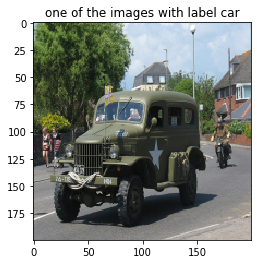

image has shape (200, 200, 3)


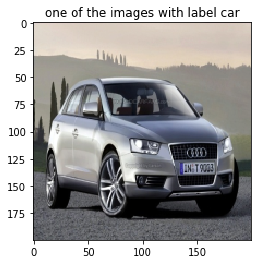

image has shape (200, 200, 3)


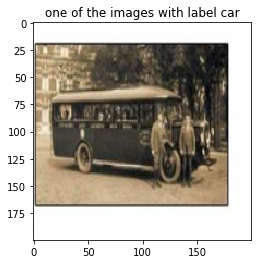

image has shape (200, 200, 3)


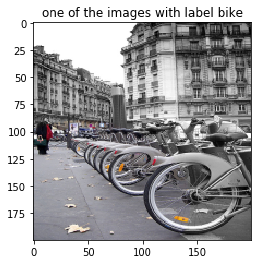

image has shape (200, 200, 3)


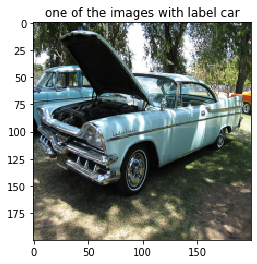

In [2]:
import os
from os import listdir
from os.path import isdir, isfile, join
import random
import numpy as np
import cv2
    
class image_dataset:
    
    #
    # Traverses all subfolders of the specified root_folder
    # and generates a list of the form:
    #
    # [ ["data/bikes/jfksdj43.jpg", "bikes",
    #   ["data/cars/bvcnm401.jpg", "cars"],
    #   ...
    # ]
    #
    def __init__(self, root_folder, img_size):
        
        self.all_images = []
       
        class_names = \
            [d for d in listdir(root_folder)
             if isdir(os.path.join(root_folder,d))]

        print("under folder\n\t", root_folder, "\nI found the following subfolders/classes:")
        print(class_names)
        
        for class_name in class_names:
            
            subfolder_name = root_folder + "/" + class_name + "/"
            
            filenames = \
                [subfolder_name + f
                 for f in listdir(subfolder_name) if isfile(join(subfolder_name, f))]
            
            print("{} files in subfolder {}".format(len(filenames), subfolder_name) )
            
            for filename in filenames:
                
                self.all_images.append( [filename, class_name] )              
        
        self.nr_images = len(self.all_images)
        print("so there are {} images in total available.".format(self.nr_images))
        
        random.shuffle( self.all_images )
        #print(self.all_images[:10])
        
        self.img_size = img_size
     
    
    #   
    # Given an absolute filename,
    # load the image in using OpenCV,
    # then convert it to usual RGB color channel order
    # resize it to standard input size
    # and scale values to be in range [0,1]
    #
    def load_image(self, absolute_filename):
        
        image = cv2.imread(absolute_filename)
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
        image = cv2.resize(image,
                           self.img_size,
                           interpolation=cv2.INTER_AREA)
        image = image * (1.0 / 255.0)
                
        return image
        
    
    #
    # Return an OpenCV image and the class label
    # where the image is chosen randomly from the
    # list of all images.
    #
    def get_random_image(self):
        
        rnd_idx = np.random.randint(0, self.nr_images)
        
        image_filename  = self.all_images[rnd_idx][0]
        image_classname = self.all_images[rnd_idx][1]
        
        image = self.load_image(image_filename)
        
        return image, image_classname
    
    
PARAM_DATASET_ROOTDIR = "/home/juebrauer/link_to_vcd/12_datasets/08_bikes_vs_cars"
PARAM_DATASET_NR_OF_EXAMPLE_IMAGES_TO_SHOW = 5
PARAM_DATASET_IMG_SHAPE = (200,200,3)
    
img_size = ( PARAM_DATASET_IMG_SHAPE[0], PARAM_DATASET_IMG_SHAPE[1] )
my_image_dataset = image_dataset( PARAM_DATASET_ROOTDIR, img_size)

import matplotlib.pyplot as plt

for i in range(0,PARAM_DATASET_NR_OF_EXAMPLE_IMAGES_TO_SHOW):
    
    image, label = my_image_dataset.get_random_image()
    print("image has shape", image.shape)
    plt.imshow(image)
    plt.title("one of the images with label {}".format(label))
    plt.show()

In [3]:
# load all images and store them into a huge NumPy array

N = my_image_dataset.nr_images
print("There are {0} images.".format(N))

nr_inputs = PARAM_DATASET_IMG_SHAPE[0] * \
            PARAM_DATASET_IMG_SHAPE[1] * \
            PARAM_DATASET_IMG_SHAPE[2]
        
x = np.zeros( (N,nr_inputs) )
print("x has shape ", x.shape)

y = np.zeros( (N, 2) )
print("y has shape ", y.shape)

img_nr = 0
for filename, label in my_image_dataset.all_images:
    
    img = my_image_dataset.load_image( filename )
        
    if img_nr % 500 == 0:
        print("images loaded: {0}".format(img_nr))
        
    x[img_nr,:] = img.reshape(-1)
    
    if label == "car" :
        y[img_nr,:] = np.array( [1.0, 0.0] )
    elif label == "bike":
        y[img_nr,:] = np.array( [0.0, 1.0] )
    else:
        print("error! unknown label!")
    
    img_nr += 1

There are 2651 images.
x has shape  (2651, 120000)
y has shape  (2651, 2)
images loaded: 0
images loaded: 500
images loaded: 1000
images loaded: 1500
images loaded: 2000
images loaded: 2500


In [4]:
train_test_ratio = 0.8
nr_train_imgs = int(N * train_test_ratio)

x_train = x[0:nr_train_imgs,:]
y_train = y[0:nr_train_imgs,:]

x_test = x[nr_train_imgs:, :]
y_test = y[nr_train_imgs:, :]

print("x_train shape: ", x_train.shape)
print("y_train shape: ", y_train.shape)

print("x_test shape: ", x_test.shape)
print("y_test shape: ", y_test.shape)

nr_test_imgs  = N-nr_train_imgs
print("nr_train_imgs: ", nr_train_imgs)
print("nr_test_imgs : ", nr_test_imgs)

x_train shape:  (2120, 120000)
y_train shape:  (2120, 2)
x_test shape:  (531, 120000)
y_test shape:  (531, 2)
nr_train_imgs:  2120
nr_test_imgs :  531


## MLP

In [ ]:
import tensorflow as tf

tf.keras.backend.clear_session()

model = keras.Sequential()
model.add(tf.keras.layers.Dense(200,
                             activation="relu",
                             input_shape=(nr_inputs,)))
model.add(tf.keras.layers.Dense(50,
                             activation="relu"))
model.add(tf.keras.layers.Dense(2,
                             activation="linear"))
model.compile(optimizer='sgd',               
              loss=tf.keras.losses.BinaryCrossentropy(),
              metrics=['accuracy'])
model.summary()

In [ ]:
model_test(model, x_test, y_test, nr_test_imgs)

In [ ]:
history = model.fit(x_train, y_train, epochs=PARAM_NR_TRAIN_EPOCHS, validation_split=0.1)

In [ ]:
model_test(model, x_test, y_test, nr_test_imgs)

## CNN

In [10]:
from tensorflow import keras
from tensorflow.keras.models import Sequential
from tensorflow.keras import layers
from tensorflow.keras.layers import Dense
from tensorflow.keras import backend as K
from tensorflow.keras import losses

K.clear_session()

model = keras.Sequential()

model.add(layers.Conv2D(16,
                        kernel_size=(11, 11),
                        strides=(5,5),
                        activation='linear',
                        input_shape=PARAM_DATASET_IMG_SHAPE
                       )
         )

model.add(layers.MaxPooling2D(pool_size=(2, 2),
                              strides=(2,2)
                             )
         )

model.add(layers.Flatten())

model.add(tf.keras.layers.Dense(128,
                                activation="relu"
                               )
         )
model.add(tf.keras.layers.Dense(2,
                                activation="linear"
                               )
         )

model.compile(optimizer='sgd',               
              loss=tf.keras.losses.MeanSquaredError(),
              metrics=['accuracy'])

model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 38, 38, 16)        5824      
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 19, 19, 16)        0         
_________________________________________________________________
flatten (Flatten)            (None, 5776)              0         
_________________________________________________________________
dense (Dense)                (None, 128)               739456    
_________________________________________________________________
dense_1 (Dense)              (None, 2)                 258       
Total params: 745,538
Trainable params: 745,538
Non-trainable params: 0
_________________________________________________________________


In [11]:
model_test(model,
           x_test,
           y_test,
           how_many_to_test=nr_test_imgs,
           model_type="CNN",
           img_shape=PARAM_DATASET_IMG_SHAPE
          )

tested so far 0 of 531 images
tested so far 100 of 531 images
tested so far 200 of 531 images
tested so far 300 of 531 images
tested so far 400 of 531 images
tested so far 500 of 531 images


0.4745762711864407

In [12]:
print("nr_train_imgs=", nr_train_imgs)
history = model.fit(x_train.reshape(nr_train_imgs,
                                    PARAM_DATASET_IMG_SHAPE[0],
                                    PARAM_DATASET_IMG_SHAPE[1],
                                    PARAM_DATASET_IMG_SHAPE[2]),
                    y_train,
                    epochs=1000,
                    validation_split=0.1)

nr_train_imgs= 2120
Train on 1908 samples, validate on 212 samples
Epoch 1/1000
1908/1908 [==============================] - 9s 5ms/sample - loss: 0.3041 - accuracy: 0.5797 - val_loss: 0.2240 - val_accuracy: 0.6934
Epoch 2/1000
1908/1908 [==============================] - 7s 4ms/sample - loss: 0.2238 - accuracy: 0.6850 - val_loss: 0.2055 - val_accuracy: 0.7075
Epoch 3/1000
1908/1908 [==============================] - 8s 4ms/sample - loss: 0.1953 - accuracy: 0.7238 - val_loss: 0.2451 - val_accuracy: 0.5943
Epoch 4/1000
1908/1908 [==============================] - 8s 4ms/sample - loss: 0.1779 - accuracy: 0.7657 - val_loss: 0.1914 - val_accuracy: 0.7453
Epoch 5/1000
1908/1908 [==============================] - 7s 4ms/sample - loss: 0.1638 - accuracy: 0.7872 - val_loss: 0.2145 - val_accuracy: 0.6415
Epoch 6/1000
1908/1908 [==============================] - 8s 4ms/sample - loss: 0.1546 - accuracy: 0.8050 - val_loss: 0.1625 - val_accuracy: 0.7642
Epoch 7/1000
1908/1908 [=====================

1908/1908 [==============================] - 7s 4ms/sample - loss: 0.0055 - accuracy: 1.0000 - val_loss: 0.1474 - val_accuracy: 0.8443
Epoch 56/1000
1908/1908 [==============================] - 7s 4ms/sample - loss: 0.0050 - accuracy: 1.0000 - val_loss: 0.1467 - val_accuracy: 0.8491
Epoch 57/1000
1908/1908 [==============================] - 8s 4ms/sample - loss: 0.0046 - accuracy: 1.0000 - val_loss: 0.1481 - val_accuracy: 0.8396
Epoch 58/1000
1908/1908 [==============================] - 7s 4ms/sample - loss: 0.0052 - accuracy: 1.0000 - val_loss: 0.1484 - val_accuracy: 0.8349
Epoch 59/1000
1908/1908 [==============================] - 8s 4ms/sample - loss: 0.0037 - accuracy: 1.0000 - val_loss: 0.1482 - val_accuracy: 0.8443
Epoch 60/1000
1908/1908 [==============================] - 7s 4ms/sample - loss: 0.0036 - accuracy: 1.0000 - val_loss: 0.1480 - val_accuracy: 0.8396
Epoch 61/1000
1908/1908 [==============================] - 7s 4ms/sample - loss: 0.0032 - accuracy: 1.0000 - val_loss: 0

1908/1908 [==============================] - 7s 4ms/sample - loss: 4.7064e-04 - accuracy: 1.0000 - val_loss: 0.1492 - val_accuracy: 0.8491
Epoch 110/1000
1908/1908 [==============================] - 7s 4ms/sample - loss: 4.2406e-04 - accuracy: 1.0000 - val_loss: 0.1490 - val_accuracy: 0.8491
Epoch 111/1000
1908/1908 [==============================] - 8s 4ms/sample - loss: 4.1326e-04 - accuracy: 1.0000 - val_loss: 0.1490 - val_accuracy: 0.8443
Epoch 112/1000
1908/1908 [==============================] - 8s 4ms/sample - loss: 4.1904e-04 - accuracy: 1.0000 - val_loss: 0.1494 - val_accuracy: 0.8491
Epoch 113/1000
1908/1908 [==============================] - 8s 4ms/sample - loss: 4.4492e-04 - accuracy: 1.0000 - val_loss: 0.1490 - val_accuracy: 0.8443
Epoch 114/1000
1908/1908 [==============================] - 7s 4ms/sample - loss: 3.8988e-04 - accuracy: 1.0000 - val_loss: 0.1494 - val_accuracy: 0.8491
Epoch 115/1000
1908/1908 [==============================] - 8s 4ms/sample - loss: 3.6879e-0

1908/1908 [==============================] - 5s 2ms/sample - loss: 1.3395e-04 - accuracy: 1.0000 - val_loss: 0.1495 - val_accuracy: 0.8396
Epoch 163/1000
1908/1908 [==============================] - 5s 3ms/sample - loss: 1.3638e-04 - accuracy: 1.0000 - val_loss: 0.1494 - val_accuracy: 0.8491
Epoch 164/1000
1908/1908 [==============================] - 5s 3ms/sample - loss: 1.3091e-04 - accuracy: 1.0000 - val_loss: 0.1496 - val_accuracy: 0.8443
Epoch 165/1000
1908/1908 [==============================] - 5s 2ms/sample - loss: 1.2442e-04 - accuracy: 1.0000 - val_loss: 0.1496 - val_accuracy: 0.8443
Epoch 166/1000
1908/1908 [==============================] - 5s 2ms/sample - loss: 1.2507e-04 - accuracy: 1.0000 - val_loss: 0.1496 - val_accuracy: 0.8491
Epoch 167/1000
1908/1908 [==============================] - 5s 3ms/sample - loss: 1.2439e-04 - accuracy: 1.0000 - val_loss: 0.1494 - val_accuracy: 0.8443
Epoch 168/1000
1908/1908 [==============================] - 5s 3ms/sample - loss: 1.4016e-0

1908/1908 [==============================] - 4s 2ms/sample - loss: 5.9195e-05 - accuracy: 1.0000 - val_loss: 0.1496 - val_accuracy: 0.8443
Epoch 216/1000
1908/1908 [==============================] - 5s 2ms/sample - loss: 6.5211e-05 - accuracy: 1.0000 - val_loss: 0.1497 - val_accuracy: 0.8396
Epoch 217/1000
1908/1908 [==============================] - 5s 3ms/sample - loss: 5.8542e-05 - accuracy: 1.0000 - val_loss: 0.1497 - val_accuracy: 0.8349
Epoch 218/1000
1908/1908 [==============================] - 5s 2ms/sample - loss: 6.0728e-05 - accuracy: 1.0000 - val_loss: 0.1497 - val_accuracy: 0.8349
Epoch 219/1000
1908/1908 [==============================] - 4s 2ms/sample - loss: 5.9267e-05 - accuracy: 1.0000 - val_loss: 0.1496 - val_accuracy: 0.8349
Epoch 220/1000
1908/1908 [==============================] - 5s 3ms/sample - loss: 5.8288e-05 - accuracy: 1.0000 - val_loss: 0.1497 - val_accuracy: 0.8349
Epoch 221/1000
1908/1908 [==============================] - 5s 2ms/sample - loss: 5.7345e-0

1908/1908 [==============================] - 4s 2ms/sample - loss: 3.4358e-05 - accuracy: 1.0000 - val_loss: 0.1498 - val_accuracy: 0.8349
Epoch 269/1000
1908/1908 [==============================] - 4s 2ms/sample - loss: 3.3764e-05 - accuracy: 1.0000 - val_loss: 0.1498 - val_accuracy: 0.8349
Epoch 270/1000
1908/1908 [==============================] - 5s 3ms/sample - loss: 3.3189e-05 - accuracy: 1.0000 - val_loss: 0.1498 - val_accuracy: 0.8349
Epoch 271/1000
1908/1908 [==============================] - 5s 3ms/sample - loss: 3.0665e-05 - accuracy: 1.0000 - val_loss: 0.1498 - val_accuracy: 0.8396
Epoch 272/1000
1908/1908 [==============================] - 5s 3ms/sample - loss: 3.0366e-05 - accuracy: 1.0000 - val_loss: 0.1498 - val_accuracy: 0.8349
Epoch 273/1000
1908/1908 [==============================] - 5s 3ms/sample - loss: 3.4466e-05 - accuracy: 1.0000 - val_loss: 0.1500 - val_accuracy: 0.8302
Epoch 274/1000
1908/1908 [==============================] - 4s 2ms/sample - loss: 3.1336e-0

1908/1908 [==============================] - 4s 2ms/sample - loss: 1.9699e-05 - accuracy: 1.0000 - val_loss: 0.1499 - val_accuracy: 0.8396
Epoch 322/1000
1908/1908 [==============================] - 4s 2ms/sample - loss: 1.9092e-05 - accuracy: 1.0000 - val_loss: 0.1498 - val_accuracy: 0.8396
Epoch 323/1000
1908/1908 [==============================] - 5s 3ms/sample - loss: 1.8845e-05 - accuracy: 1.0000 - val_loss: 0.1498 - val_accuracy: 0.8396
Epoch 324/1000
1908/1908 [==============================] - 5s 2ms/sample - loss: 1.8224e-05 - accuracy: 1.0000 - val_loss: 0.1498 - val_accuracy: 0.8349
Epoch 325/1000
1908/1908 [==============================] - 5s 3ms/sample - loss: 1.8405e-05 - accuracy: 1.0000 - val_loss: 0.1498 - val_accuracy: 0.8349
Epoch 326/1000
1908/1908 [==============================] - 5s 3ms/sample - loss: 1.8742e-05 - accuracy: 1.0000 - val_loss: 0.1499 - val_accuracy: 0.8349
Epoch 327/1000
1908/1908 [==============================] - 5s 2ms/sample - loss: 1.8020e-0

1908/1908 [==============================] - 5s 3ms/sample - loss: 1.1819e-05 - accuracy: 1.0000 - val_loss: 0.1499 - val_accuracy: 0.8396
Epoch 375/1000
1908/1908 [==============================] - 4s 2ms/sample - loss: 1.1656e-05 - accuracy: 1.0000 - val_loss: 0.1499 - val_accuracy: 0.8396
Epoch 376/1000
1908/1908 [==============================] - 5s 3ms/sample - loss: 1.1581e-05 - accuracy: 1.0000 - val_loss: 0.1499 - val_accuracy: 0.8396
Epoch 377/1000
1908/1908 [==============================] - 5s 3ms/sample - loss: 1.1805e-05 - accuracy: 1.0000 - val_loss: 0.1498 - val_accuracy: 0.8396
Epoch 378/1000
1908/1908 [==============================] - 5s 3ms/sample - loss: 1.2180e-05 - accuracy: 1.0000 - val_loss: 0.1499 - val_accuracy: 0.8349
Epoch 379/1000
1908/1908 [==============================] - 5s 2ms/sample - loss: 1.1536e-05 - accuracy: 1.0000 - val_loss: 0.1498 - val_accuracy: 0.8396
Epoch 380/1000
1908/1908 [==============================] - 5s 3ms/sample - loss: 1.1305e-0

1908/1908 [==============================] - 4s 2ms/sample - loss: 7.9923e-06 - accuracy: 1.0000 - val_loss: 0.1499 - val_accuracy: 0.8349
Epoch 428/1000
1908/1908 [==============================] - 5s 3ms/sample - loss: 7.9173e-06 - accuracy: 1.0000 - val_loss: 0.1499 - val_accuracy: 0.8396
Epoch 429/1000
1908/1908 [==============================] - 4s 2ms/sample - loss: 7.8134e-06 - accuracy: 1.0000 - val_loss: 0.1499 - val_accuracy: 0.8396
Epoch 430/1000
1908/1908 [==============================] - 5s 3ms/sample - loss: 7.8684e-06 - accuracy: 1.0000 - val_loss: 0.1498 - val_accuracy: 0.8396
Epoch 431/1000
1908/1908 [==============================] - 4s 2ms/sample - loss: 7.7548e-06 - accuracy: 1.0000 - val_loss: 0.1499 - val_accuracy: 0.8396
Epoch 432/1000
1908/1908 [==============================] - 5s 2ms/sample - loss: 7.6635e-06 - accuracy: 1.0000 - val_loss: 0.1499 - val_accuracy: 0.8349
Epoch 433/1000
1908/1908 [==============================] - 5s 3ms/sample - loss: 7.5406e-0

1908/1908 [==============================] - 5s 3ms/sample - loss: 5.6011e-06 - accuracy: 1.0000 - val_loss: 0.1499 - val_accuracy: 0.8349
Epoch 481/1000
1908/1908 [==============================] - 5s 3ms/sample - loss: 5.7290e-06 - accuracy: 1.0000 - val_loss: 0.1499 - val_accuracy: 0.8396
Epoch 482/1000
1908/1908 [==============================] - 5s 3ms/sample - loss: 5.5870e-06 - accuracy: 1.0000 - val_loss: 0.1499 - val_accuracy: 0.8396
Epoch 483/1000
1908/1908 [==============================] - 5s 3ms/sample - loss: 5.4960e-06 - accuracy: 1.0000 - val_loss: 0.1499 - val_accuracy: 0.8396
Epoch 484/1000
1908/1908 [==============================] - 5s 3ms/sample - loss: 5.5164e-06 - accuracy: 1.0000 - val_loss: 0.1499 - val_accuracy: 0.8396
Epoch 485/1000
1908/1908 [==============================] - 4s 2ms/sample - loss: 5.3829e-06 - accuracy: 1.0000 - val_loss: 0.1499 - val_accuracy: 0.8396
Epoch 486/1000
1908/1908 [==============================] - 5s 3ms/sample - loss: 7.5318e-0

1908/1908 [==============================] - 5s 3ms/sample - loss: 4.1241e-06 - accuracy: 1.0000 - val_loss: 0.1499 - val_accuracy: 0.8396
Epoch 534/1000
1908/1908 [==============================] - 5s 3ms/sample - loss: 4.1604e-06 - accuracy: 1.0000 - val_loss: 0.1499 - val_accuracy: 0.8396
Epoch 535/1000
1908/1908 [==============================] - 4s 2ms/sample - loss: 4.1441e-06 - accuracy: 1.0000 - val_loss: 0.1499 - val_accuracy: 0.8396
Epoch 536/1000
1908/1908 [==============================] - 5s 3ms/sample - loss: 4.0962e-06 - accuracy: 1.0000 - val_loss: 0.1499 - val_accuracy: 0.8396
Epoch 537/1000
1908/1908 [==============================] - 5s 2ms/sample - loss: 4.0204e-06 - accuracy: 1.0000 - val_loss: 0.1498 - val_accuracy: 0.8396
Epoch 538/1000
1908/1908 [==============================] - 4s 2ms/sample - loss: 4.1427e-06 - accuracy: 1.0000 - val_loss: 0.1499 - val_accuracy: 0.8349
Epoch 539/1000
1908/1908 [==============================] - 4s 2ms/sample - loss: 4.0163e-0

1908/1908 [==============================] - 5s 3ms/sample - loss: 3.2585e-06 - accuracy: 1.0000 - val_loss: 0.1499 - val_accuracy: 0.8396
Epoch 587/1000
1908/1908 [==============================] - 5s 2ms/sample - loss: 3.1561e-06 - accuracy: 1.0000 - val_loss: 0.1499 - val_accuracy: 0.8349
Epoch 588/1000
1908/1908 [==============================] - 5s 3ms/sample - loss: 3.1904e-06 - accuracy: 1.0000 - val_loss: 0.1499 - val_accuracy: 0.8396
Epoch 589/1000
1908/1908 [==============================] - 5s 3ms/sample - loss: 3.2047e-06 - accuracy: 1.0000 - val_loss: 0.1499 - val_accuracy: 0.8396
Epoch 590/1000
1908/1908 [==============================] - 5s 3ms/sample - loss: 3.2506e-06 - accuracy: 1.0000 - val_loss: 0.1499 - val_accuracy: 0.8396
Epoch 591/1000
1908/1908 [==============================] - 5s 3ms/sample - loss: 3.1515e-06 - accuracy: 1.0000 - val_loss: 0.1499 - val_accuracy: 0.8396
Epoch 592/1000
1908/1908 [==============================] - 5s 2ms/sample - loss: 3.0861e-0

1908/1908 [==============================] - 5s 2ms/sample - loss: 2.5099e-06 - accuracy: 1.0000 - val_loss: 0.1498 - val_accuracy: 0.8396
Epoch 640/1000
1908/1908 [==============================] - 5s 2ms/sample - loss: 2.4960e-06 - accuracy: 1.0000 - val_loss: 0.1499 - val_accuracy: 0.8396
Epoch 641/1000
1908/1908 [==============================] - 4s 2ms/sample - loss: 2.4515e-06 - accuracy: 1.0000 - val_loss: 0.1499 - val_accuracy: 0.8396
Epoch 642/1000
1908/1908 [==============================] - 5s 3ms/sample - loss: 2.4079e-06 - accuracy: 1.0000 - val_loss: 0.1498 - val_accuracy: 0.8396
Epoch 643/1000
1908/1908 [==============================] - 5s 3ms/sample - loss: 2.3786e-06 - accuracy: 1.0000 - val_loss: 0.1498 - val_accuracy: 0.8396
Epoch 644/1000
1908/1908 [==============================] - 5s 3ms/sample - loss: 2.5790e-06 - accuracy: 1.0000 - val_loss: 0.1499 - val_accuracy: 0.8396
Epoch 645/1000
1908/1908 [==============================] - 5s 2ms/sample - loss: 2.4021e-0

1908/1908 [==============================] - 5s 2ms/sample - loss: 2.1204e-06 - accuracy: 1.0000 - val_loss: 0.1499 - val_accuracy: 0.8396
Epoch 693/1000
1908/1908 [==============================] - 5s 2ms/sample - loss: 1.9399e-06 - accuracy: 1.0000 - val_loss: 0.1499 - val_accuracy: 0.8396
Epoch 694/1000
1908/1908 [==============================] - 5s 2ms/sample - loss: 2.1011e-06 - accuracy: 1.0000 - val_loss: 0.1499 - val_accuracy: 0.8396
Epoch 695/1000
1908/1908 [==============================] - 5s 3ms/sample - loss: 1.9804e-06 - accuracy: 1.0000 - val_loss: 0.1499 - val_accuracy: 0.8396
Epoch 696/1000
1908/1908 [==============================] - 4s 2ms/sample - loss: 2.1481e-06 - accuracy: 1.0000 - val_loss: 0.1498 - val_accuracy: 0.8396
Epoch 697/1000
1908/1908 [==============================] - 4s 2ms/sample - loss: 1.9726e-06 - accuracy: 1.0000 - val_loss: 0.1498 - val_accuracy: 0.8396
Epoch 698/1000
1908/1908 [==============================] - 5s 2ms/sample - loss: 1.8947e-0

1908/1908 [==============================] - 5s 3ms/sample - loss: 1.6163e-06 - accuracy: 1.0000 - val_loss: 0.1498 - val_accuracy: 0.8396
Epoch 746/1000
1908/1908 [==============================] - 4s 2ms/sample - loss: 1.5812e-06 - accuracy: 1.0000 - val_loss: 0.1498 - val_accuracy: 0.8396
Epoch 747/1000
1908/1908 [==============================] - 5s 3ms/sample - loss: 1.5899e-06 - accuracy: 1.0000 - val_loss: 0.1498 - val_accuracy: 0.8396
Epoch 748/1000
1908/1908 [==============================] - 5s 3ms/sample - loss: 1.5777e-06 - accuracy: 1.0000 - val_loss: 0.1498 - val_accuracy: 0.8396
Epoch 749/1000
1908/1908 [==============================] - 5s 3ms/sample - loss: 1.5466e-06 - accuracy: 1.0000 - val_loss: 0.1498 - val_accuracy: 0.8396
Epoch 750/1000
1908/1908 [==============================] - 5s 3ms/sample - loss: 1.5491e-06 - accuracy: 1.0000 - val_loss: 0.1498 - val_accuracy: 0.8396
Epoch 751/1000
1908/1908 [==============================] - 5s 3ms/sample - loss: 1.5877e-0

1908/1908 [==============================] - 5s 3ms/sample - loss: 1.3336e-06 - accuracy: 1.0000 - val_loss: 0.1498 - val_accuracy: 0.8396
Epoch 799/1000
1908/1908 [==============================] - 4s 2ms/sample - loss: 1.3437e-06 - accuracy: 1.0000 - val_loss: 0.1498 - val_accuracy: 0.8396
Epoch 800/1000
1908/1908 [==============================] - 5s 3ms/sample - loss: 1.3158e-06 - accuracy: 1.0000 - val_loss: 0.1498 - val_accuracy: 0.8396
Epoch 801/1000
1908/1908 [==============================] - 5s 3ms/sample - loss: 1.3609e-06 - accuracy: 1.0000 - val_loss: 0.1498 - val_accuracy: 0.8396
Epoch 802/1000
1908/1908 [==============================] - 5s 3ms/sample - loss: 1.3392e-06 - accuracy: 1.0000 - val_loss: 0.1498 - val_accuracy: 0.8396
Epoch 803/1000
1908/1908 [==============================] - 4s 2ms/sample - loss: 1.3088e-06 - accuracy: 1.0000 - val_loss: 0.1498 - val_accuracy: 0.8396
Epoch 804/1000
1908/1908 [==============================] - 5s 2ms/sample - loss: 1.3255e-0

1908/1908 [==============================] - 5s 3ms/sample - loss: 1.1337e-06 - accuracy: 1.0000 - val_loss: 0.1498 - val_accuracy: 0.8396
Epoch 852/1000
1908/1908 [==============================] - 5s 3ms/sample - loss: 1.1616e-06 - accuracy: 1.0000 - val_loss: 0.1498 - val_accuracy: 0.8396
Epoch 853/1000
1908/1908 [==============================] - 5s 3ms/sample - loss: 1.1263e-06 - accuracy: 1.0000 - val_loss: 0.1498 - val_accuracy: 0.8396
Epoch 854/1000
1908/1908 [==============================] - 5s 3ms/sample - loss: 1.1095e-06 - accuracy: 1.0000 - val_loss: 0.1498 - val_accuracy: 0.8396
Epoch 855/1000
1908/1908 [==============================] - 5s 2ms/sample - loss: 1.1456e-06 - accuracy: 1.0000 - val_loss: 0.1498 - val_accuracy: 0.8396
Epoch 856/1000
1908/1908 [==============================] - 5s 3ms/sample - loss: 1.1001e-06 - accuracy: 1.0000 - val_loss: 0.1498 - val_accuracy: 0.8396
Epoch 857/1000
1908/1908 [==============================] - 5s 3ms/sample - loss: 1.1080e-0

1908/1908 [==============================] - 4s 2ms/sample - loss: 9.6839e-07 - accuracy: 1.0000 - val_loss: 0.1498 - val_accuracy: 0.8396
Epoch 905/1000
1908/1908 [==============================] - 5s 3ms/sample - loss: 9.8520e-07 - accuracy: 1.0000 - val_loss: 0.1498 - val_accuracy: 0.8396
Epoch 906/1000
1908/1908 [==============================] - 5s 2ms/sample - loss: 9.3660e-07 - accuracy: 1.0000 - val_loss: 0.1498 - val_accuracy: 0.8396
Epoch 907/1000
1908/1908 [==============================] - 5s 3ms/sample - loss: 9.5787e-07 - accuracy: 1.0000 - val_loss: 0.1498 - val_accuracy: 0.8396
Epoch 908/1000
1908/1908 [==============================] - 5s 2ms/sample - loss: 9.3328e-07 - accuracy: 1.0000 - val_loss: 0.1498 - val_accuracy: 0.8396
Epoch 909/1000
1908/1908 [==============================] - 5s 2ms/sample - loss: 9.5237e-07 - accuracy: 1.0000 - val_loss: 0.1498 - val_accuracy: 0.8396
Epoch 910/1000
1908/1908 [==============================] - 4s 2ms/sample - loss: 9.4001e-0

1908/1908 [==============================] - 5s 3ms/sample - loss: 8.6128e-07 - accuracy: 1.0000 - val_loss: 0.1498 - val_accuracy: 0.8396
Epoch 958/1000
1908/1908 [==============================] - 5s 3ms/sample - loss: 8.3508e-07 - accuracy: 1.0000 - val_loss: 0.1498 - val_accuracy: 0.8396
Epoch 959/1000
1908/1908 [==============================] - 5s 2ms/sample - loss: 8.1422e-07 - accuracy: 1.0000 - val_loss: 0.1498 - val_accuracy: 0.8396
Epoch 960/1000
1908/1908 [==============================] - 4s 2ms/sample - loss: 8.2847e-07 - accuracy: 1.0000 - val_loss: 0.1498 - val_accuracy: 0.8396
Epoch 961/1000
1908/1908 [==============================] - 4s 2ms/sample - loss: 8.0456e-07 - accuracy: 1.0000 - val_loss: 0.1498 - val_accuracy: 0.8396
Epoch 962/1000
1908/1908 [==============================] - 5s 2ms/sample - loss: 8.0350e-07 - accuracy: 1.0000 - val_loss: 0.1498 - val_accuracy: 0.8396
Epoch 963/1000
1908/1908 [==============================] - 5s 3ms/sample - loss: 8.1985e-0

In [13]:
model_test(model,
           x_test,
           y_test,
           how_many_to_test=nr_test_imgs,
           model_type="CNN",
           img_shape=PARAM_DATASET_IMG_SHAPE
          )

tested so far 0 of 531 images
tested so far 100 of 531 images
tested so far 200 of 531 images
tested so far 300 of 531 images
tested so far 400 of 531 images
tested so far 500 of 531 images


0.7947269303201506

# Results

| Model         | Dataset       | Acc test data  | Nr train epochs |
|---------------|---------------|----------------|-----------------|
| Perceptron    | MNIST         | 85%            | 300             |
| MLP 200-50-10 | MNIST         | 97%            | 300             |
| CNN           | MNIST         | TODO!          | 150             |
| Perceptron    | Fashion-MNIST | 81%            | 300             |
| MLP 200-50-10 | Fashion-MNIST | 88%            | 300             |
| CNN           | Fashion-MNIST | 84%            | 150             |
| MLP 200-50-10 | Bikes vs. Cars| 47% (=random!) | 100             |
| CNN           | Bikes vs. Cars| 79%            | 1000            |